# Multi Fidelity optimization

In [38]:
from jax import config

# Double precision is highly recommended.
config.update("jax_enable_x64", True)

from jax import jit
from jax import lax
from jax import nn
from jax import numpy as jnp
from jax import random
from jax import value_and_grad
from jax import scipy
from jax import vmap

import optax
import matplotlib.pyplot as plt

from boax.core import distributions, samplers
from boax.prediction import kernels, means, models, objectives
from boax.optimization import acquisitions, maximizers

In [2]:
bounds = jnp.array([[-5.0, 5.0]])

In [3]:
def objective(x):
    return -((x[..., 0] + 1) ** 2) * jnp.sin(2 * x[..., 0] + 2) / 5 + 1 + x[..., 0] / 3
 
def approximate(x):
    return 0.5 * objective(x) + x[..., 0] / 4 + 2

In [4]:
fidelities = jnp.array([0.5, 1.0])

In [27]:
data_key, sampler_key, maximizer_key = random.split(random.key(0), 3)

f_train = random.randint(random.fold_in(data_key, 0), minval=0, maxval=2, shape=(10,))

x_train = random.uniform(random.fold_in(data_key, 1), minval=bounds[:, 0], maxval=bounds[:, 1], shape=(10, 1))
x_fid = fidelities[f_train][..., jnp.newaxis]

y_obj = objective(x_train)
y_approx = approximate(x_train)
y_train = jnp.where(f_train, y_obj, y_approx)

In [28]:
xs = jnp.linspace(-5, 5, 501)[..., jnp.newaxis]
ys_obj = objective(xs)
ys_approx = approximate(xs)

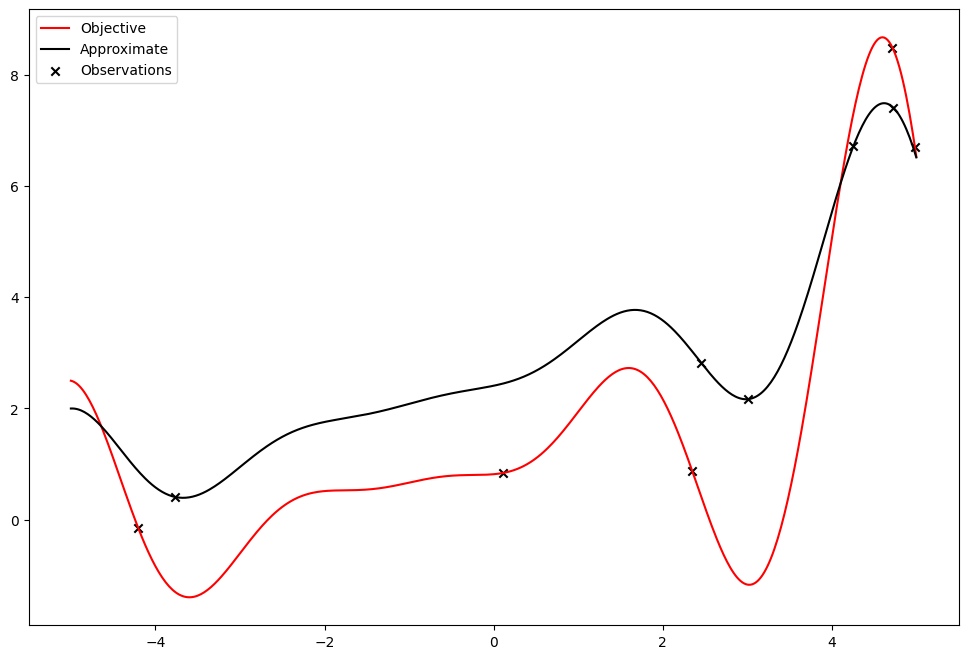

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(xs, ys_obj, color='r', label='Objective')
ax.plot(xs, ys_approx, linestyle='-', color='k', label='Approximate')
ax.scatter(x_train, y_train, marker='x', color='k', label='Observations')

plt.legend()
plt.show()

In [30]:
def prior(constant, amplitude, unbiased_length_scale, biased_length_scale, power):
    return models.gaussian_process(
        means.constant(constant),
        kernels.scaled(
            kernels.linear_truncated(
                x_fid,
                x_fid,
                kernels.matern_five_halves(nn.softplus(unbiased_length_scale)),
                kernels.matern_five_halves(nn.softplus(biased_length_scale)),
                nn.softplus(power)
            ),
            nn.softplus(amplitude)
        ),
        1e-4
    )

In [31]:
def target_log_prob(params):
    y_hat = prior(**params)(x_train)
    return -objectives.exact_marginal_log_likelihood()(y_hat, y_train)

In [32]:
params = {
    'constant': jnp.zeros(()),
    'amplitude': jnp.zeros(()),
    'unbiased_length_scale': jnp.zeros(()),
    'biased_length_scale': jnp.zeros(()),
    'power': jnp.zeros(()),
}

In [33]:
optimizer = optax.adam(0.01)

In [34]:
def train_step(state, iteration):
    loss, grads = value_and_grad(target_log_prob)(state[0])
    updates, opt_state = optimizer.update(grads, state[1])
    params = optax.apply_updates(state[0], updates)
    
    return (params, opt_state), loss

In [35]:
(next_params, next_opt_state), history = lax.scan(
    jit(train_step),
    (params, optimizer.init(params)),
    jnp.arange(500)
)

In [36]:
def posterior(constant, amplitude, unbiased_length_scale, biased_length_scale, power):
    return models.multi_fidelity_regression(
        x_train,
        x_fid,
        y_train,
        means.constant(constant),
        lambda fid1, fid2: kernels.scaled(
            kernels.linear_truncated(
                fid1,
                fid2,
                kernels.matern_five_halves(nn.softplus(unbiased_length_scale)),
                kernels.matern_five_halves(nn.softplus(biased_length_scale)),
                nn.softplus(power)
            ),
            nn.softplus(amplitude)
        ),
        1e-4
    )

In [37]:
surrogate = posterior(**next_params)

In [39]:
ys_hat = distributions.multivariate_normal.as_normal(surrogate(xs))

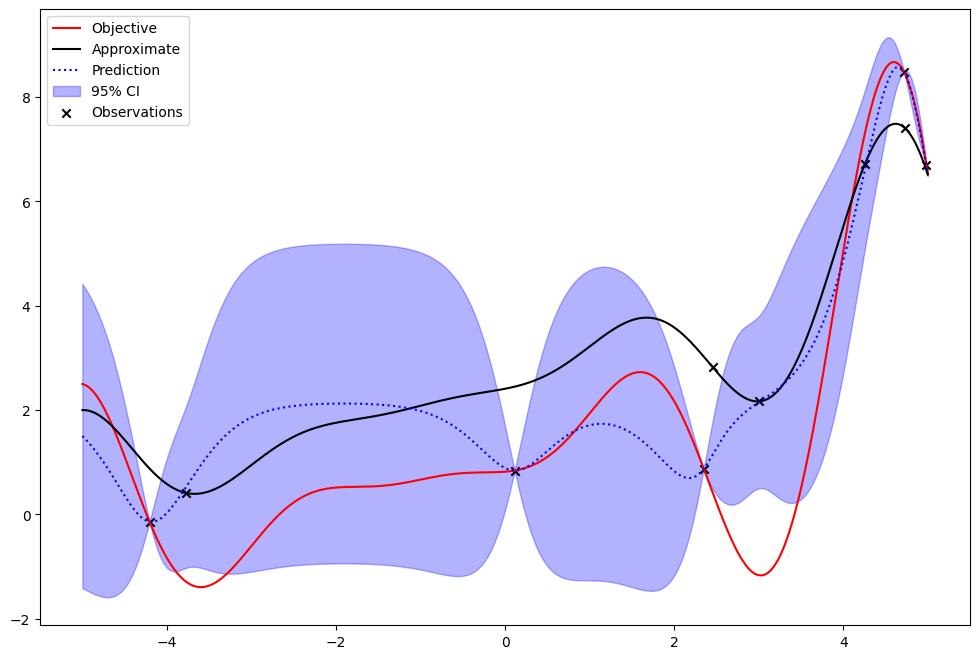

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(xs, ys_obj, color='r', label='Objective')
ax.plot(xs, ys_approx, linestyle='-', color='k', label='Approximate')

ax.plot(xs, ys_hat.loc, linestyle='dotted', color='b', label='Prediction')
ax.fill_between(
    xs[..., 0],
    ys_hat.loc - 2 * ys_hat.scale,
    ys_hat.loc + 2 * ys_hat.scale,
    color='b', label='95% CI',
    alpha=0.3
)

ax.scatter(x_train, y_train, marker='x', color='k', label='Observations')

plt.legend()
plt.show()

In [ ]:
weights